# Parts-of-speech (POS) Tagging
In this assignment we will perform POS tagging using RNNs.
For the task, we will use treebank with universal tagset. It consists of a total of 3914 samples with a total of 12 different tags.
You need to perform the following:
- Create the model structure which will, at least, include the following: embedding layer, RNN layer(s), and the output dense layer for many-to-many sequence modeling.
- Train the system using train set. Use 15% of the train set as validation data during the call to the fit() function
- Do the final evaluation on the test set using accurcay as the main metric. **Important note: while computing the accurcay make sure not to include the padding in the input and the output. Otherwise your accuracy score may be unrealistically high. Similarly, you can use ``mask_zero=True`` in the Embedding layer during training**


## Read the dataset

In [47]:
import numpy as np
import nltk
from matplotlib import pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Dense, Input, TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

In [48]:
from nltk.corpus import treebank
nltk.download('treebank')
nltk.download('universal_tagset')
treebank_corpus = treebank.tagged_sents(tagset='universal')
len(treebank_corpus)

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\0xboja\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\0xboja\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


3914

### Check a sample

In [49]:
treebank_corpus[0]

[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET'),
 ('board', 'NOUN'),
 ('as', 'ADP'),
 ('a', 'DET'),
 ('nonexecutive', 'ADJ'),
 ('director', 'NOUN'),
 ('Nov.', 'NOUN'),
 ('29', 'NUM'),
 ('.', '.')]

## Split the data into iput and output

In [50]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in treebank_corpus:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [51]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
tag_set = set([word for sentence in Y for word in sentence])
num_tags   = len(tag_set)
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))
print("Tage set:",tag_set)

Total number of tagged sentences: 3914
Vocabulary size: 11387
Total number of tags: 12
Tage set: {'ADP', 'DET', 'ADV', 'NOUN', '.', 'NUM', 'PRON', 'X', 'PRT', 'ADJ', 'CONJ', 'VERB'}


In [52]:
# let's look at first data point
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

sample Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 



In [53]:
# check length of longest sentence
lengths = [len(seq) for seq in X]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 271


In [54]:
# encode X
from tensorflow.keras.preprocessing.text import Tokenizer
word_tokenizer = Tokenizer()                      # instantiate tokeniser
word_tokenizer.fit_on_texts(X)                    # fit tokeniser on data
X_encoded = word_tokenizer.texts_to_sequences(X)  # use the tokeniser to encode input sequence

In [55]:
# encode Y
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

In [56]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.'] 

Y:  ['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'ADJ', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3] 

Y:  [1, 1, 3, 8, 1, 7, 3, 2, 2, 5, 1, 4, 5, 7, 1, 1, 8, 3] 



## 1. Padd the sequences

In [57]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_SEQ_LENGTH = 100  

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")


In [58]:
X, Y = X_padded, Y_padded
Y = to_categorical(Y)

## Split The dataset into Train and Test

In [59]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.30

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=777)

In [60]:

VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=777)

In [61]:

print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (2328, 100)
Shape of output sequences: (2328, 100, 13)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (411, 100)
Shape of output sequences: (411, 100, 13)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (1175, 100)
Shape of output sequences: (1175, 100, 13)


### 2. Develop an RNN-based Model 
The RNN can be LSTM, GRU, or even Bidirectional ones
You need to at least the following:
- An embedding layer
- One or more RNN layers
- An output dense layer with softmax activation

Once you develop your model architecture, you need to compile and train it. use 15% of training data during fit as validataion data.

Plot the training and validation losses

In [62]:

EMBEDDING_SIZE  = 100
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
print(VOCABULARY_SIZE)
NUM_CLASSES = Y.shape[2]

11388


In [63]:
# create architecture

rnn_model = Sequential()

rnn_model.add(Embedding(input_dim     =  VOCABULARY_SIZE,     
                        output_dim    =  EMBEDDING_SIZE,          
                        input_length  =  MAX_SEQ_LENGTH,      
                        trainable     =  True                   
))

rnn_model.add(SimpleRNN(64, 
              return_sequences=True
))


rnn_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [64]:
rnn_model.compile(loss      =  'categorical_crossentropy',
                  optimizer =  'adam',
                  metrics   =  ['acc'])

In [65]:

rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1138800   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           10560     
                                                                 
 time_distributed_2 (TimeDis  (None, 100, 13)          845       
 tributed)                                                       
                                                                 
Total params: 1,150,205
Trainable params: 1,150,205
Non-trainable params: 0
_________________________________________________________________


In [66]:
rnn_training = rnn_model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_data=(X_validation, Y_validation))

Epoch 1/20
19/19 [==============================] - 1s 37ms/step - loss: 1.5153 - acc: 0.7104 - val_loss: 0.9401 - val_acc: 0.7577
Epoch 2/20
19/19 [==============================] - 1s 30ms/step - loss: 0.8173 - acc: 0.7763 - val_loss: 0.7522 - val_acc: 0.7854
Epoch 3/20
19/19 [==============================] - 1s 31ms/step - loss: 0.6910 - acc: 0.8085 - val_loss: 0.6413 - val_acc: 0.8048
Epoch 4/20
19/19 [==============================] - 1s 31ms/step - loss: 0.5830 - acc: 0.8305 - val_loss: 0.5701 - val_acc: 0.8342
Epoch 5/20
19/19 [==============================] - 1s 31ms/step - loss: 0.5211 - acc: 0.8611 - val_loss: 0.5326 - val_acc: 0.8594
Epoch 6/20
19/19 [==============================] - 1s 31ms/step - loss: 0.4699 - acc: 0.8826 - val_loss: 0.4589 - val_acc: 0.8993
Epoch 7/20
19/19 [==============================] - 1s 30ms/step - loss: 0.3993 - acc: 0.9160 - val_loss: 0.3929 - val_acc: 0.9126
Epoch 8/20
19/19 [==============================] - 1s 30ms/step - loss: 0.3317 - a

## 3. Evaluate on the test set
Once you finalize the model based on validation set loss and accuracy, you should do the final evaluation on the test set.

**Important note: while computing the accurcay make sure not to include the padding in the input and the output. Otherwise your accuracy score may be unrealistically high.**

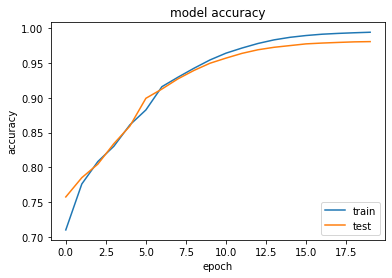

In [67]:

plt.plot(rnn_training.history['acc'])
plt.plot(rnn_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()

In [68]:
loss, accuracy = rnn_model.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy*100))

37/37 [==============================] - 0s 4ms/step - loss: 0.0759 - acc: 0.9811
Loss: 0.07585166394710541,
Accuracy: 98.11404347419739
